In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

from dataset import *
from utils import *
from model import *
from trainer import *


In [2]:
conf = load_options('config.yml')
# conf

# Dataset

In [3]:
dconf = conf['dataset']
set_chars = set(dconf['set_chars'])

transforms = tv.transforms.Compose([
    tv.transforms.ToPILImage(),
    tv.transforms.ColorJitter(brightness=.5, hue=.5),
    # tv.transforms.Grayscale(3),
    tv.transforms.RandomRotation(10, fill=255),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ds_train = DatasetText(dconf['train_path'], 
                       dconf['train_labels'], 
                       transforms, set_chars, 
                       dconf['max_len'])


transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ds_test = DatasetText(dconf['test_path'], 
                       dconf['test_labels'], 
                       transforms, set_chars, 
                       dconf['max_len'])


train_loader = torch.utils.data.DataLoader(
    ds_train, shuffle=dconf['shuffle'],
    batch_size=dconf['batch_size'], num_workers=0, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    ds_test, shuffle=False,
    batch_size=dconf['batch_size'], num_workers=0, drop_last=False)

Count data: 59031
Count data: 1080


In [4]:
# for batch in train_loader:
#     print(batch['img'].shape)
#     break

# for ind in range(5):
#     print(batch['label'][ind])
#     img_transform = batch['img'][ind].permute(1, 2, 0).numpy()
#     plt.figure(figsize=(2, 6))
#     plt.imshow(img_transform)
#     plt.show();

# можно фильтровать данные, содержащие несколько слов

# Train

In [ ]:
chars = sorted(list(set_chars))
print(chars)
tp = TextProcessor(chars)
vocab_size = tp.get_vocab_size()


[' ', '!', '"', '%', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '№']


In [ ]:
model = CRNN_v4a(vocab_size)

weights = 'Model_Recognize/CRNN_v4a_epoch_18_2024-11-25_17:33:46_weights.pt'
model = load_model_weights(model, weights)

model = model.to(dconf['device'])

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=1e-4)

/home/daniluck505/Documents/Projects/OCR_task/.conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/daniluck505/Documents/Projects/OCR_task/utils.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling

In [9]:
trainer = Trainer(model, optimizer, calculate_loss, tp, train_loader, test_loader, 5)

In [10]:
if len(trainer.train_loss) == 0:
    load_opt = load_results('Model_Recognize/CRNN_v4a_epoch_18_2024-11-25_17:33:46_results.pkl')
    trainer.train_loss = load_opt['loss_history']
    trainer.val_loss = load_opt['val_history']
    trainer.epoch_sum = int(input())
    conf = load_opt['options']


In [14]:
trainer.optim = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, nesterov=True)
# trainer.optim = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999))

In [15]:
tconf = {'epochs': 2,
         'validate': True,
         'device': 'cuda'}

trainer.train_model(tconf)

Epoch: 23	loss: 0.352: 100%|██████████| 686/686 [02:28<00:00,  4.61it/s]


Train loss: 0.360
Val loss: 0.885




Epoch: 24	loss: 0.260: 100%|██████████| 686/686 [02:27<00:00,  4.66it/s]


Train loss: 0.341
Val loss: 0.899




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


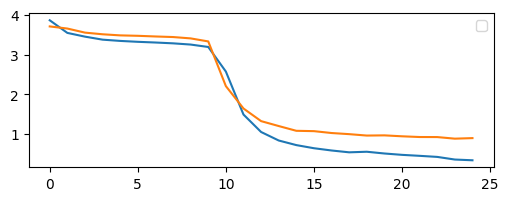

In [16]:
trainer.plot_history((6, 2))

# Validate

In [ ]:
loss = 0
for i, batch in enumerate(test_loader):
    print(f'Batch {i}')
    loss += trainer.batch_validate(batch, dconf['device'], False)
mean_loss = loss / (i+1)
print(f'data mean WER: {mean_loss:.2f}')

Batch 0
0: ибо - ибо
1: осталось - осталось
2: поле - поге
3: 1 класса - 1 класса
4: паспорт - паспорт
5: назначение - назнячение
6: отправление - отпровиение
7: было только - бымо тольно
8: 6.10.2017г. - 6.10.2017г.
9: которые для - которые дия
10: тогда - тогда
11: отправления были - правления ъым
12: критичны. - критисны.
13: в ситуации, - в ситуаци,
14: 30. 08. 2004 - 30.09.г20оч
15: дав обратную - дав обратную
16: связь - свзь
17: а также - а также
18: которые были - которые были
19: оплачены за - опляачешы за
20: способ - спосод
21: 1 класса - 1 нласод
22: приложена - приоженя
23: заявлению - залвлению,
24: 7.10.2017 г. - 7.10.207г.
25: угольник - суольмик
26: 10 июня 2016г. - 10 мюни 016г.
27: 15.02.1987г. - 15.02.1287г.
28: рождения - рошзения
29: 17.10.2005 - 12.10 200
30: паспорт серия - ноаемонт ания
31: 18.03.2007 г - 18.03.07г,
32: по адресу - но адресу
33: деньги - деныи
34: рублей - нблеей
35: 18.04.1980 - 18.04.1980
36: паспорт серия - пасоноы. сеция
37: зарегистрирован

# Save

In [20]:
save_results(conf, model, trainer.train_loss, trainer.val_loss, trainer.epoch_sum)